## Imports

In [1]:

%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

import scanpy as sc
from anndata import AnnData, concat

import matplotlib.pyplot as plt
import matplotlib_venn as venn
import seaborn as sns

from scipy import sparse, stats
from scipy.cluster import hierarchy
import pymn
import gc
from upsetplot import plot as UpSet
from itertools import product
import networkx as nx


import re
import h5py

import itertools

import statsmodels.api as sm

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize



In [3]:
%matplotlib inline

In [4]:
#These save characters as text in PDFs
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

#These change plot aesthetics

sns.set(style='white', font_scale=1.25)
plt.rc("axes.spines", top=False, right=False)
plt.rc('xtick', bottom=True)
plt.rc('ytick', left=True)

In [5]:
sc.settings.verbosity = 3

In [6]:
import sys
sys.path.append('/home/bharris/pseudotime/scripts/')
from mn_utils import *

In [7]:
from move_seaborn_legend import move_legend

In [8]:
import mkl


In [9]:
mkl.set_num_threads(8)

48

In [10]:
import enrichment_stats

## Functions

In [11]:
get_bin = np.vectorize(lambda x: int(x.split('|')[-1].split('_')[-1]))

In [587]:
def plot_umaps(df, hue, plot_lins=False, **kwargs):
    """
    Hue must be either a named pd.Series or string in df
    """
    mask = df.new_lineage=='nan'
    df = df[~mask]
    if type(hue) is not str:
        hue = hue[~mask]
    g = sns.relplot(data=df,
                    x='monocle_UMAP1',
                    y='monocle_UMAP2',
                    col='Study',
                    col_wrap=3,
                    hue=hue,
                    s=5,
                    **kwargs)
    g.set_titles('{col_name}')
    roots = combined_metadata.loc[combined_metadata.groupby('Study')
                                  ['monocle_ps'].idxmin().values]
    roots['new_lineage'] = 'Root'
    leaves = combined_metadata.loc[combined_metadata.groupby(
        ['new_lineage', 'Study'])['monocle_ps'].idxmax().values]
    ends = pd.concat([roots, leaves])

    for ax, study in zip(g.fig.axes, g.col_names):
        ends_study = ends[ends.Study == study].set_index('new_lineage')
        if plot_lins:
            ax.text(ends_study.loc['Erythroid', 'monocle_UMAP1'],
                    ends_study.loc['Erythroid', 'monocle_UMAP2'], 'Erythroid')
            ax.text(ends_study.loc['Monocyte', 'monocle_UMAP1'],
                    ends_study.loc['Monocyte', 'monocle_UMAP2'], 'Monocyte')
            ax.text(ends_study.loc['Root', 'monocle_UMAP1'],
                    ends_study.loc['Root', 'monocle_UMAP2'], 'Root')
        ax.axis('off')
    plt.show()

In [13]:
def compute_bins(pseudotime, n_bins):
    return pd.cut(pseudotime, n_bins,
                  labels=np.arange(n_bins).astype(str)).astype(str)

In [14]:
from statsmodels.distributions.empirical_distribution import ECDF


def calc_fdr(empirical_dist, null_dist, flip_order=False):
    if flip_order:
        empirical_dist = 1 - empirical_dist

    empirical_order = np.argsort(empirical_dist)
    empirical_sorted = empirical_dist[empirical_order]
    null_sorted = np.sort(null_dist)
    
    ecdf_func = ECDF(empirical_sorted)
    empirical_cdf = ecdf_func(empirical_sorted)    

    ncdf_func = ECDF(null_sorted)
    null_cdf = ncdf_func(empirical_cdf)
    
    fdr_unorder = null_cdf / empirical_cdf
    
    fdr_unorder[fdr_unorder > 1] = 1
    result = np.zeros_like(fdr_unorder)
    result[empirical_order] = fdr_unorder
    return result

    

In [15]:
def compute_p_adj(p_vals, n_samples=1e8, flip_order=False):
    empirical = p_vals.rank(pct=True).mean(axis=1)
    n_dataset = p_vals.shape[1]
    null_dist = np.random.uniform(size=[int(n_samples), n_dataset]).mean(axis=1)
    p_adj = calc_fdr(empirical, null_dist, flip_order=flip_order)
    return p_adj

In [16]:
def compute_log_p_value(p_adj):
    log_offset = p_adj[p_adj != 0].min()
    return np.log10(p_adj + log_offset) * -1

In [17]:
def get_pval_by_study(df, study_col='study', gene_col='Gene', p_val_col='pval'):
    return df.reset_index().pivot(columns=study_col,
                                  index=gene_col,
                                  values=p_val_col)

## Load Data

In [19]:
go_mouse = pd.read_hdf('/home/bharris/GO_data/go_mouse_nw.hdf5', 'go')

go_annots = pd.read_csv('/home/bharris/GO_data/go_annotation_descriptions.csv',
                        index_col='X')
go_annots.columns = ['idx', 'description', 'category']
go_annots.index.name = 'GO Term'
go_annots.drop(columns='idx', inplace=True)
go_annots.head()

,description,category
GO Term,,
GO:0000001,mitochondrion inheritance,biological_process
GO:0000002,mitochondrial genome maintenance,biological_process
GO:0000003,reproduction,biological_process
GO:0000005,obsolete ribosomal chaperone activity,molecular_function
GO:0000006,high-affinity zinc transmembrane transporter a...,molecular_function


In [20]:
combined_adata = sc.read('/home/bharris/pseudotime/data/monocle/erythroid_and_monocyte_lineage_adata_no_gaps.h5ad')
# sc.pp.normalize_total(combined_adata, target_sum=1e6)
# sc.pp.log1p(combined_adata)

erythroid_adata = combined_adata[combined_adata.obs.new_lineage == 'Erythroid']
monocyte_adata = combined_adata[combined_adata.obs.new_lineage == 'Monocyte']

combined_metadata = combined_adata.obs

In [584]:
combined_adata.obs['Study'] = [x[0].upper() + ''.join(re.findall(r'\d+',x)) for x in combined_adata.obs.study_id]

In [21]:
sets_used = np.genfromtxt(
    '/home/bharris/pseudotime/data/monocle/metaneighbor/go_terms_to_use.csv',
    dtype=str)
genes_used = erythroid_adata.var_names
go_used = go_mouse.reindex(genes_used, axis=0).dropna().reindex(sets_used,
                                                                axis=1)

In [22]:
def rescale(x):
    y = x - x.min()
    return y / y.max()


combined_adata.obs['rescaled_ps'] = combined_adata.obs.groupby(
    ['study_id', 'new_lineage'])['monocle_ps'].apply(rescale)
combined_adata.obs['ranked_ps'] = combined_adata.obs.groupby(
    ['study_id', 'new_lineage'])['monocle_ps'].rank(pct=True)

erythroid_adata.obs['rescaled_ps'] = erythroid_adata.obs.groupby(
    ['study_id', 'new_lineage'])['monocle_ps'].apply(rescale)
erythroid_adata.obs['ranked_ps'] = erythroid_adata.obs.groupby(
    ['study_id', 'new_lineage'])['monocle_ps'].rank(pct=True)

monocyte_adata.obs['rescaled_ps'] = monocyte_adata.obs.groupby(
    ['study_id', 'new_lineage'])['monocle_ps'].apply(rescale)
monocyte_adata.obs['ranked_ps'] = monocyte_adata.obs.groupby(
    ['study_id', 'new_lineage'])['monocle_ps'].rank(pct=True)

bin_sizes = [2, 4, 8, 16, 32, 64]
for n_bins in bin_sizes:
    combined_adata.obs[f'ps_{n_bins}'] = compute_bins(
        combined_adata.obs.ranked_ps, n_bins)
    monocyte_adata.obs[f'ps_{n_bins}'] = compute_bins(
        monocyte_adata.obs.ranked_ps, n_bins)
    erythroid_adata.obs[f'ps_{n_bins}'] = compute_bins(
        erythroid_adata.obs.ranked_ps, n_bins)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [23]:
pymn.variableGenes(combined_adata, 'study_id')

In [24]:
joining = np.vectorize(lambda x, y: f'{x}_{y}')
combined_adata.obs['ps_32_lineage'] = joining(combined_adata.obs.new_lineage,
                                              combined_adata.obs.ps_32)
combined_adata.obs['ps_16_lineage'] = joining(combined_adata.obs.new_lineage,
                                              combined_adata.obs.ps_16)
combined_adata.obs.study_id = combined_adata.obs.study_id.astype(str)



pymn.MetaNeighborUS(combined_adata,
                    'study_id',
                    'ps_16_lineage',
                    fast_version=True)

In [25]:
combined_adata.obs.to_csv(
    '/home/bharris/pseudotime/data/monocle/gene_models/combined_adata_obs_no_gaps.csv')

## Compute Aggregate Stats

In [433]:
a='giladi'
all_studies_lineage_test.query('study == @a')

,Gene,status,family,pval,qval,study
98345,0610007P14Rik,FAIL,negbinomial.size,1.0,1.0,giladi
98346,0610009B22Rik,FAIL,negbinomial.size,1.0,1.0,giladi
98347,0610009O20Rik,FAIL,negbinomial.size,1.0,1.0,giladi
98348,0610011F06Rik,FAIL,negbinomial.size,1.0,1.0,giladi
98349,0610030E20Rik,FAIL,negbinomial.size,1.0,1.0,giladi
...,...,...,...,...,...,...
110633,Zyg11b,FAIL,negbinomial.size,1.0,1.0,giladi
110634,Zyx,FAIL,negbinomial.size,1.0,1.0,giladi
110635,Zzef1,FAIL,negbinomial.size,1.0,1.0,giladi
110636,Zzz3,FAIL,negbinomial.size,1.0,1.0,giladi


In [438]:
all_studies_lineage_test = pd.read_csv(
    '/home/bharris/pseudotime/data/monocle/gene_models/all_studies_BEAM_lineage_test_no_gaps.csv',
    index_col=0)

all_studies_pseudotime_test = pd.read_csv(
    '/home/bharris/pseudotime/data/monocle/gene_models/all_studies_BEAM_pseudotime_test_no_gaps.csv',
    index_col=0)
all_studies_eryth_ps_test = pd.read_csv(
    '/home/bharris/pseudotime/data/monocle/gene_models/all_studies_BEAM_pseudotime_test_erythroid_no_gaps.csv',
    index_col=0)
all_studies_monocyte_ps_test = pd.read_csv(
    '/home/bharris/pseudotime/data/monocle/gene_models/all_studies_BEAM_pseudotime_test_monocyte_no_gaps.csv',
    index_col=0)

In [444]:
ok_results_ps = (all_studies_pseudotime_test.pivot(
    index='Gene', columns='study', values='status') == 'OK').sum(axis=1)

ok_results_lineage = (all_studies_lineage_test.pivot(
    index='Gene', columns='study', values='status') == 'OK').sum(axis=1)

ok_genes = ok_results_lineage.index[(ok_results_ps >= 6) & (ok_results_lineage >= 6)]
all_studies_lineage_test_agg = pd.DataFrame()

In [445]:
centroids = combined_adata.to_df().groupby(
    [combined_adata.obs.new_lineage, combined_adata.obs.study_id]).mean()
fc_by_study = np.log2((centroids.loc['Erythroid'] + 1) / (centroids.loc['Monocyte'] + 1))
fc = fc_by_study.mean()

In [446]:
all_scatterplotdies_lineage_test_agg['fc'] = fc
all_studies_lineage_test_agg = all_studies_lineage_test_agg.loc[ok_genes]

In [515]:
all_studies_lineage_test_agg['avg_expr'] = combined_adata.to_df().groupby(combined_adata.obs.study_id).mean().rank(axis=1,pct=True).mean()

In [535]:
all_studies_lineage_test_agg['most_significant'] = all_studies_lineage_test_agg.p_adj==0

In [447]:
all_studies_lineage_test_agg['p_adj'] = compute_p_adj(
    get_pval_by_study(all_studies_lineage_test).loc[ok_genes])
all_studies_lineage_test_agg['p_adj_pseudotime'] = compute_p_adj(
    get_pval_by_study(all_studies_pseudotime_test).loc[ok_genes])
all_studies_lineage_test_agg['p_adj_eryth'] = compute_p_adj(
    get_pval_by_study(all_studies_eryth_ps_test).loc[ok_genes])
all_studies_lineage_test_agg['p_adj_mono'] = compute_p_adj(
    get_pval_by_study(all_studies_monocyte_ps_test).loc[ok_genes])

In [491]:
all_studies_lineage_test_agg['-log10padj'] = compute_log_p_value(
    all_studies_lineage_test_agg.p_adj)
all_studies_lineage_test_agg['-log10padj_ps'] = compute_log_p_value(
    all_studies_lineage_test_agg.p_adj_pseudotime)
all_studies_lineage_test_agg['-log10padj_eryth'] = compute_log_p_value(
    all_studies_lineage_test_agg.p_adj_eryth)
all_studies_lineage_test_agg['-log10padj_mono'] = compute_log_p_value(
    all_studies_lineage_test_agg.p_adj_mono)


In [690]:
all_studies_lineage_test_agg.to_csv('/home/bharris/pseudotime/supplementary_tables/supplementary_table_4.csv.gz')

In [700]:
all_studies_lineage_test_agg.to_csv('/home/bharris/pseudotime/supplementary_tables/supplementary_table_4.csv')

In [35]:
erythroid_sorted = all_studies_lineage_test_agg.sort_values(
    ['p_adj', 'p_adj_eryth', 'fc'], ascending=[True, True,
                                               False]).reset_index()

erythroid_sorted['rank'] = erythroid_sorted.index + 1

monocyte_sorted = all_studies_lineage_test_agg.sort_values(
    ['p_adj', 'p_adj_mono', 'fc'], ascending=[True, True, True]).reset_index()

monocyte_sorted['rank'] = monocyte_sorted.index + 1

In [644]:
combined_adata.obs.groupby(['scNym','study_id']).size()['erythroblast']

study_id
cheng            1
dahlin           1
giladi           0
rf_LARRY1        0
tusi_batch1     10
tusi_batch2      0
weinreb2         0
weinreb9       243
weinreb16        0
dtype: int64

In [98]:
all_studies_lineage_test_agg.groupby(all_studies_lineage_test_agg.fc > 0).apply(lambda x: stats.spearmanr(x['-log10padj_eryth'], x['-log10padj_mono'])[0])

fc
False    0.645616
True     0.716588
dtype: float64

In [41]:
correct_by_study = lambda x : compute_log_p_value(sm.stats.fdrcorrection(x)[1])
eryth_pval_by_study = (get_pval_by_study(all_studies_eryth_ps_test)
                       .apply(correct_by_study)
                       .reset_index()
                       .melt(id_vars='Gene',
                             value_name='Monocyte Padj')
                       .set_index('Gene'))

mono_pval_by_study = (get_pval_by_study(all_studies_monocyte_ps_test)
                      .apply(correct_by_study)
                      .reset_index()
                      .melt(id_vars='Gene', 
                            value_name='Erythroid Padj')
                      .set_index('Gene'))


In [44]:
monocyte_sorted.to_csv(
    '/home/bharris/pseudotime/data/monocle/gene_models/aggregate_stats_monocyte_no_gaps.csv'
)
erythroid_sorted.to_csv(
    '/home/bharris/pseudotime/data/monocle/gene_models/aggregate_stats_erythroid_no_gaps.csv'
)

In [648]:
monocyte_sorted

,Gene,fc,p_adj,p_adj_pseudotime,p_adj_eryth,p_adj_mono,-log10padj,-log10padj_ps,-log10padj_eryth,-log10padj_mono,rank
0,Hp,-1.345565,0.0,0.000000e+00,1.000000,0.0,6.809259e+00,6.806073,-7.811411e-08,6.810527e+00,1
1,Tyrobp,-1.315816,0.0,1.576820e-07,0.000000,0.0,6.809259e+00,6.503111,6.745055e+00,6.810527e+00,2
2,Hk3,-1.305627,0.0,0.000000e+00,0.000639,0.0,6.809259e+00,6.806073,3.194339e+00,6.810527e+00,3
3,Anxa3,-1.284464,0.0,0.000000e+00,0.006342,0.0,6.809259e+00,6.806073,2.197770e+00,6.810527e+00,4
4,Slpi,-1.282531,0.0,0.000000e+00,0.000006,0.0,6.809259e+00,6.806073,5.236079e+00,6.810527e+00,5
...,...,...,...,...,...,...,...,...,...,...,...
10607,Atg4b,0.252469,1.0,2.122864e-03,0.000295,1.0,-6.737913e-08,2.673046,3.529313e+00,-6.718269e-08,10608
10608,Pacsin2,0.263454,1.0,2.762162e-03,0.000023,1.0,-6.737913e-08,2.558726,4.634771e+00,-6.718269e-08,10609
10609,Ccdc74a,0.276244,1.0,7.910022e-04,0.000080,1.0,-6.737913e-08,3.101737,4.095635e+00,-6.718269e-08,10610
10610,Rabgef1,0.291759,1.0,4.490848e-04,0.000500,1.0,-6.737913e-08,3.347521,3.301045e+00,-6.718269e-08,10611


In [651]:
monocyte_sorted[['Gene','fc','p_adj','p_adj_eryth','p_adj_mono']].to_csv('/tyrone-data/bharris/for_john/pseudotime_statistics.csv')

In [45]:
np.savetxt(
    '/home/bharris/pseudotime/data/monocle/gene_models/top_50_monocyte_genes_no_gaps.csv',
    monocyte_sorted.Gene.values[:50],
    fmt='%
np.savetxt(
    '/home/bharris/pseudotime/data/monocle/gene_models/top_50_erythroid_genes_no_gaps.csv',
    erythroid_sorted.Gene.values[:50],
    fmt='%s')

In [46]:
markers_df = pd.DataFrame(
    {
        'Monocyte': np.in1d(go_used.index, monocyte_sorted.Gene.values[:50]),
        'Erythroid': np.in1d(go_used.index, erythroid_sorted.Gene.values[:50])
    },
    index=go_used.index).astype(float)
markers_enrichmnet = enrichment_stats.enrich_multi_markers(markers_df, go_used)

In [47]:
top_50_design = pd.DataFrame(index=combined_adata.var_names,columns=['Erythroid_lineage','Monocyte_lineage'])
top_50_design['Erythroid_lineage'] = np.in1d(top_50_design.index, erythroid_sorted.Gene.values[:50])
top_50_design['Monocyte_lineage'] = np.in1d(top_50_design.index, monocyte_sorted.Gene.values[:50])

In [48]:
top_50_design.to_csv('/home/bharris/pseudotime/scripts/mn_pipeline/data/lineage_associated_top_50_no_gaps.csv')


In [50]:
top_eryth_by_study = fc_by_study.T.idxmax().values
erythroid_sorted.query('Gene in @top_eryth_by_study')

,Gene,fc,p_adj,p_adj_pseudotime,p_adj_eryth,p_adj_mono,-log10padj,-log10padj_ps,-log10padj_eryth,-log10padj_mono,rank
0,Klf1,1.309097,0.000000,0.000000,0.000000,1.000000,6.809259,6.806073,6.745055,-6.718269e-08,1
1,Gata1,1.258148,0.000000,0.000000,0.000000,0.012053,6.809259,6.806073,6.745055,1.918888e+00,2
3,Car1,1.198135,0.000000,0.000000,0.000000,0.029684,6.809259,6.806073,6.745055,1.527477e+00,4
10,Car2,1.053542,0.000000,0.000000,0.000000,0.000000,6.809259,6.806073,6.745055,6.810527e+00,11
11,Atp1b2,1.049816,0.000000,0.000000,0.000000,0.645316,6.809259,6.806073,6.745055,1.902273e-01,12
2640,Gzmb,0.135229,0.015002,0.000054,0.000000,0.369027,1.823833,4.264756,6.745055,4.329415e-01,2641
3011,Pbk,0.240570,0.040442,0.000000,0.000001,0.000004,1.393169,6.806073,5.824452,5.431391e+00,3012


In [52]:
top_mono_by_study = fc_by_study.T.idxmin().values
monocyte_sorted.query('Gene in @top_mono_by_study')

,Gene,fc,p_adj,p_adj_pseudotime,p_adj_eryth,p_adj_mono,-log10padj,-log10padj_ps,-log10padj_eryth,-log10padj_mono,rank
0,Hp,-1.345565,0.0,0.0,1.000000e+00,0.000000e+00,6.809259,6.806073,-7.811411e-08,6.810527,1
7,Igsf6,-1.205666,0.0,0.0,6.854816e-01,0.000000e+00,6.809259,6.806073,1.640041e-01,6.810527,8
9,Ctsg,-1.171751,0.0,0.0,1.287816e-05,0.000000e+00,6.809259,6.806073,4.884123e+00,6.810527,10
12,Ms4a3,-1.093102,0.0,0.0,9.865073e-07,0.000000e+00,6.809259,6.806073,5.933163e+00,6.810527,13
19,Lyz2,-1.026181,0.0,0.0,0.000000e+00,0.000000e+00,6.809259,6.806073,6.745055e+00,6.810527,20
20,Serpinb1a,-1.024863,0.0,0.0,4.555777e-04,0.000000e+00,6.809259,6.806073,3.341266e+00,6.810527,21
149,Ltb,-0.213953,0.0,0.0,0.000000e+00,0.000000e+00,6.809259,6.806073,6.745055e+00,6.810527,150
348,Alox5ap,-1.084218,0.0,0.0,0.000000e+00,3.075942e-07,6.809259,6.806073,6.745055e+00,6.335087,349


## GO Enrichment

In [663]:
full_enrichment_tidy = markers_enrichmnet.reset_index().melt(id_vars='go_id',value_name='Padj')
full_enrichment_tidy['description'] = go_annots.reindex(full_enrichment_tidy.go_id)['description'].values
full_enrichment_tidy['Term Size'] = go_used.sum()[full_enrichment_tidy.go_id].values
full_enrichment_tidy.dropna(inplace=True)
full_enrichment_tidy.rename(columns={'variable':'Lineage'},inplace=True)
full_enrichment_tidy.to_csv('/tyrone-data/bharris/for_john/pseudotime_go_enrichment.csv')

In [55]:
markers_enrichmnet_tidy = markers_enrichmnet.reset_index().melt(
    id_vars='go_id', value_name='Padj').query('Padj <.05')
markers_enrichmnet_tidy['description'] = go_annots.loc[
    markers_enrichmnet_tidy['go_id'], 'description'].values

markers_enrichmnet_tidy['term_size'] = go_used.sum()[
    markers_enrichmnet_tidy['go_id']].values
markers_enrichmnet_tidy['-log10(Padj)'] = -1 * np.log10(markers_enrichmnet_tidy.Padj)

In [99]:
markers_enrichmnet_tidy.sort_values(['variable', 'Padj'])

,go_id,variable,Padj,description,term_size
9218,GO:0048821,Erythroid,0.000072,erythrocyte development,22.0
9779,GO:0061515,Erythroid,0.000072,myeloid cell development,42.0
7520,GO:0030218,Erythroid,0.000545,erythrocyte differentiation,66.0
8113,GO:0034101,Erythroid,0.001031,erythrocyte homeostasis,77.0
5810,GO:0002262,Erythroid,0.003226,myeloid cell homeostasis,97.0
...,...,...,...,...,...
941,GO:0006959,Monocyte,0.032408,humoral immune response,77.0
401,GO:0002888,Monocyte,0.036578,positive regulation of myeloid leukocyte media...,33.0
3249,GO:0045055,Monocyte,0.036578,regulated exocytosis,80.0
1080,GO:0008037,Monocyte,0.038519,cell recognition,82.0


In [693]:
markers_enrichmnet_tidy_all = markers_enrichmnet.reset_index().melt(
    id_vars='go_id', value_name='Padj')
markers_enrichmnet_tidy_all['description'] = go_annots.reindex(
    markers_enrichmnet_tidy_all['go_id'])['description'].values

markers_enrichmnet_tidy_all['term_size'] = go_used.sum()[
    markers_enrichmnet_tidy_all['go_id']].values
markers_enrichmnet_tidy_all['-log10(Padj)'] = -1 * np.log10(markers_enrichmnet_tidy_all.Padj)

In [697]:
markers_enrichmnet_tidy_all.dropna().to_csv('/home/bharris/pseudotime/supplementary_tables/supplementary_table_5.csv.gz')

In [687]:
markers_enrichmnet_tidy.groupby('variable').size()

variable
Erythroid    11
Monocyte     54
dtype: int64

In [253]:
markers_enrichmnet_tidy['Padj_rank'] = markers_enrichmnet_tidy.groupby('variable')['Padj'].rank()

In [264]:
markers_enrichmnet_tidy.go_id = markers_enrichmnet_tidy.go_id.astype(str)

In [604]:

top_5_eryth = erythroid_sorted.query('rank <=5').Gene.values
top_5_mono = monocyte_sorted.query('rank <=5').Gene.values
dotplot_and_MA_genes = np.concatenate([top_5_eryth,top_5_mono])

/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "transparet" which is no longer supported as of 3.3 and will become an error two minor releases later
  app.launch_new_instance()


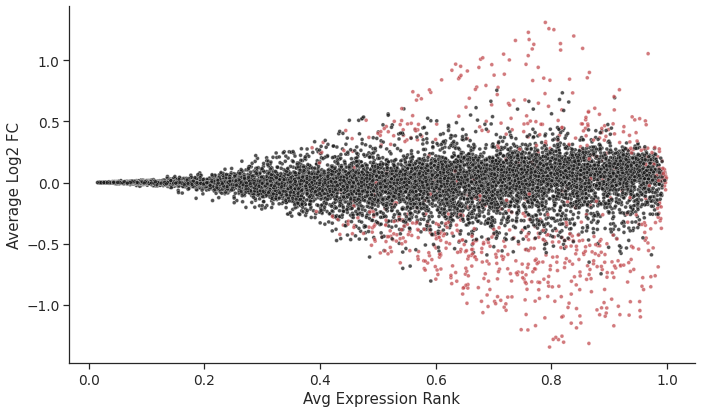

In [611]:
fig, ax = plt.subplots(figsize=(10,6))
ax=sns.scatterplot(data=all_studies_lineage_test_agg,
                   x='avg_expr',
                   y='fc',
                   s=15,
                   hue='most_significant',
                   palette=['k','r'],
                   alpha=.75,
                   legend=False,
                   rasterized=True)
ax.set(xlabel='Avg Expression Rank',
       ylabel='Average Log2 FC')

plt.tight_layout()
plt.savefig('/home/bharris/pseudotime/figures/pseudotime_gene_signatures/volano_plot.pdf',
            transparet=True)

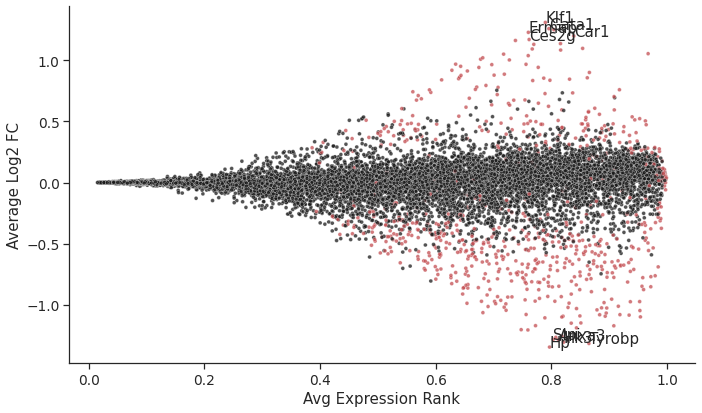

In [613]:
fig, ax = plt.subplots(figsize=(10,6))
ax=sns.scatterplot(data=all_studies_lineage_test_agg,
                   x='avg_expr',
                   y='fc',
                   s=15,
                   hue='most_significant',
                   palette=['k','r'],
                   alpha=.75,
                   legend=False,
                   rasterized=True)
ax.set(xlabel='Avg Expression Rank',
       ylabel='Average Log2 FC')
for row in all_studies_lineage_test_agg.query('Gene in @dotplot_and_MA_genes').itertuples():
    ax.text(row.avg_expr, row.fc, row.Index)
plt.tight_layout()
plt.savefig('/home/bharris/pseudotime/figures/pseudotime_gene_signatures/volano_plot_annot.pdf',
            transparent=True)

/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/seaborn/categorical.py:3795: UserWarning: Setting `sharey=False` with `color=None` may cause different levels of the `y` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharey", "y"), UserWarning)
/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(*args, **kwargs)


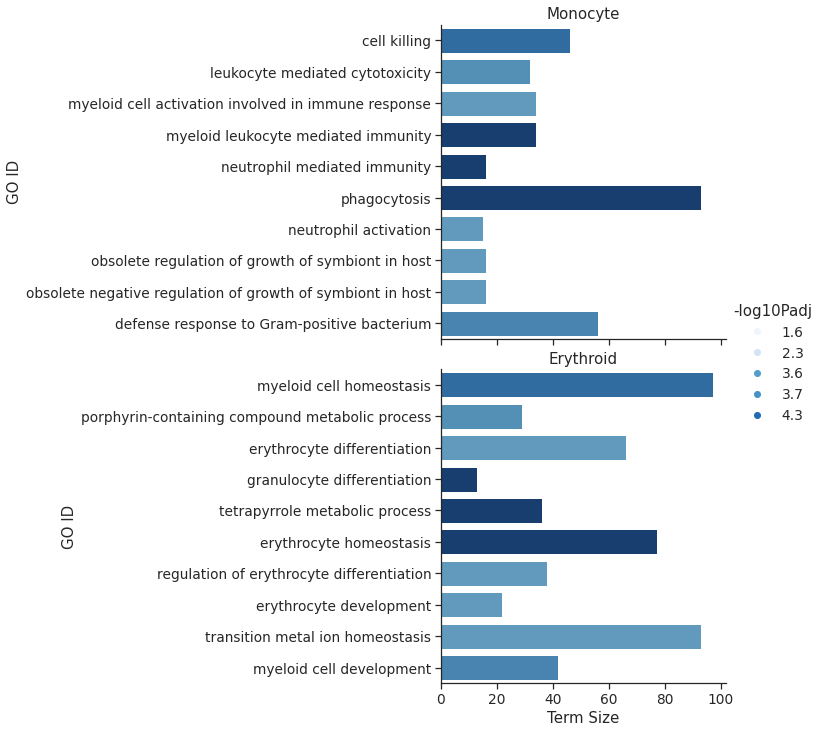

In [595]:
def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]
    normalized = (values - min(values)) / (max(values) - min(values))
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

n_terms = 10
g = sns.catplot(data=markers_enrichmnet_tidy.query('Padj_rank <= @n_terms'),
                x='term_size',
                y='description',
                kind='bar',
                row='variable',
                palette=colors_from_values(markers_enrichmnet_tidy.query('Padj_rank <= @n_terms')['-log10(Padj)'],'Blues'),
                sharey=False)
g.set_titles('{row_name}')
g.set_xlabels('Term Size')
g.set_ylabels('GO ID')

legend_vals = np.round(markers_enrichmnet_tidy.query('Padj_rank <= @n_terms')['-log10(Padj)'].sort_values()[::2],1)
legend_colors = colors_from_values(markers_enrichmnet_tidy.query('Padj_rank <= @n_terms')['-log10(Padj)'].sort_values(),'Blues')[::2,:]
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in legend_colors]
ax2 = g.fig.add_axes([.2,.2,1,0.4])
ax2.axis('off')
ax2.legend(markers[::2], legend_vals[::2], frameon=False, title='-log10Padj')
g.savefig('/home/bharris/pseudotime/figures/pseudotime_gene_signatures/top_go_signatures.pdf',
          transparent=True)

In [57]:
markers_enrichmnet_tidy.to_csv(
    '/home/bharris/pseudotime/data/monocle/gene_models/marker_enrichment_tidy_no_gaps.csv'
)

In [667]:
top_markers =pd.read_csv('/home/bharris/pseudotime/data/markers/droplet_top_50_markers_design.csv',index_col=0)

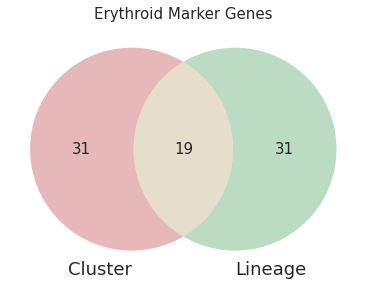

In [684]:
venn.venn2([set(top_markers.index[top_markers.proerythroblast.astype(bool)]), 
            set(top_50_design.index[top_50_design.Erythroid_lineage])], 
           set_labels=['Cluster','Lineage'])
plt.tight_layout()
plt.title('Erythroid Marker Genes')
plt.savefig('/home/bharris/pseudotime/figures/supplements/marker_overlap_erythroid.pdf',
            transparent=True)


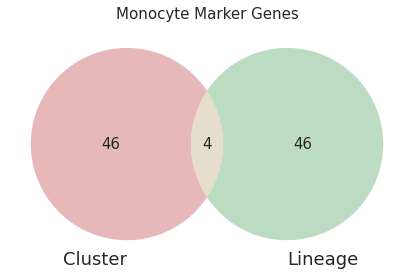

In [685]:

venn.venn2([set(top_markers.index[top_markers.monocyte.astype(bool)]), 
            set(top_50_design.index[top_50_design.Monocyte_lineage])], 
           set_labels=['Cluster','Lineage'])
plt.tight_layout()
plt.title('Monocyte Marker Genes')
plt.savefig('/home/bharris/pseudotime/figures/supplements/marker_overlap_monocyte.pdf',
            transparent=True)


##  Dotplots

In [128]:
def select_cells(study, lin, ascending=True):
    return combined_adata.obs.query('new_lineage == @lin & study_id == @study').sort_values('monocle_ps',ascending=ascending).index

In [221]:
scaled_adata = sc.pp.scale(combined_adata[:,np.concatenate([top_5_eryth,top_5_mono])],
                           copy=True)
vmax = scaled_adata.to_df().max().max()

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


dahlin


/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


weinreb2


/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


weinreb9


/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


weinreb16


/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


tusi_batch1


/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


tusi_batch2
rf_LARRY1


/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


cheng


/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


giladi


/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


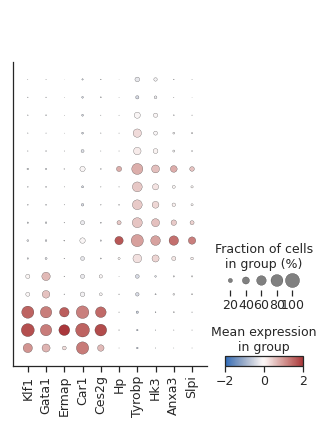

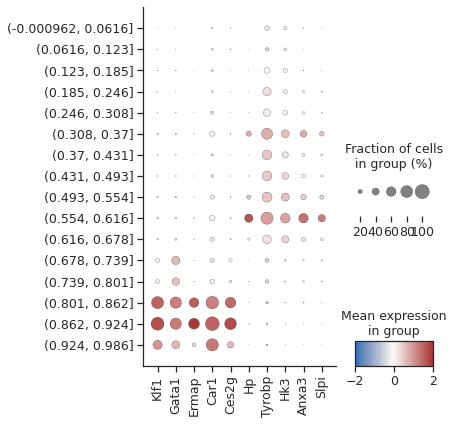

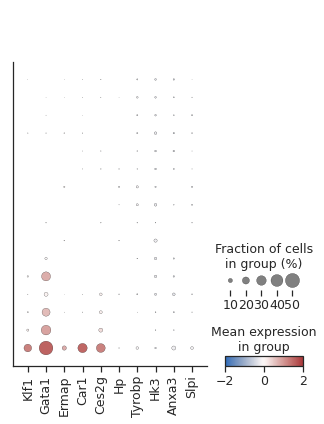

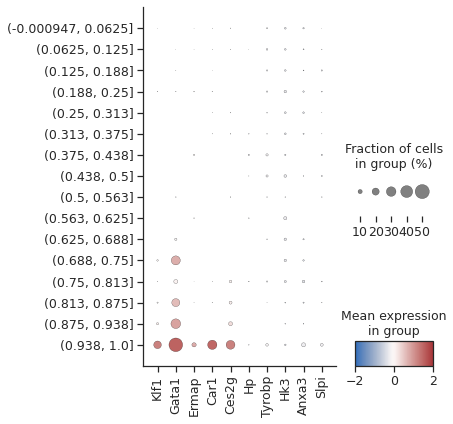

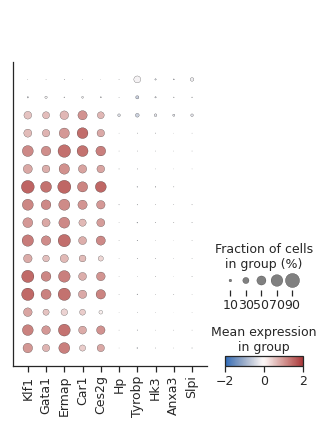

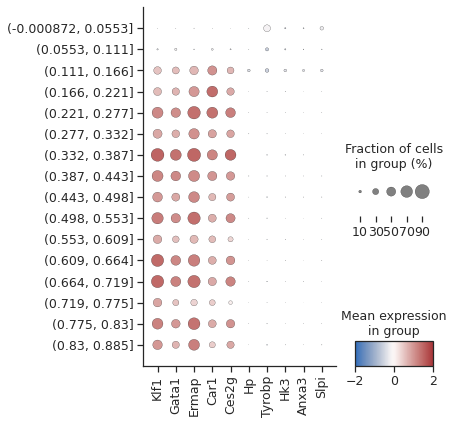

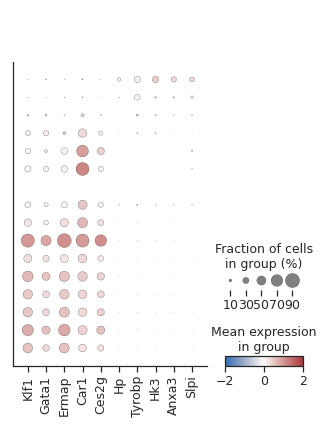

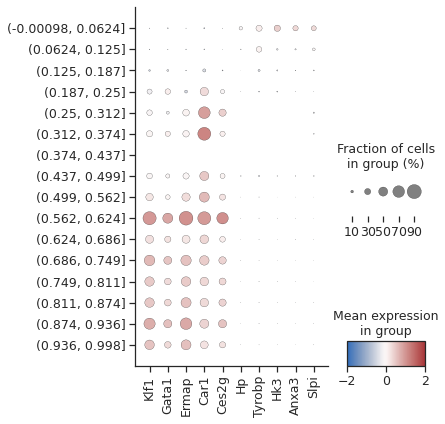

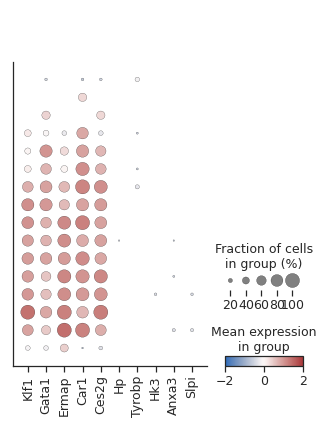

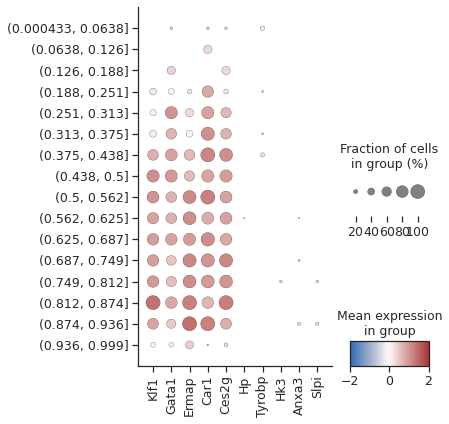

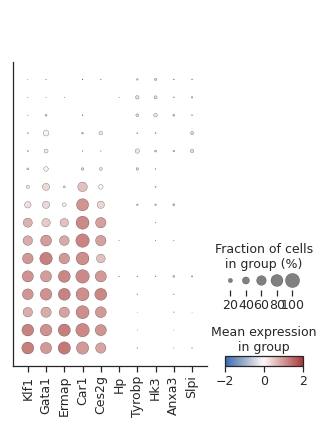

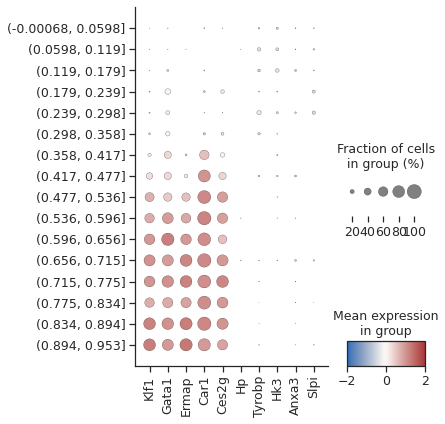

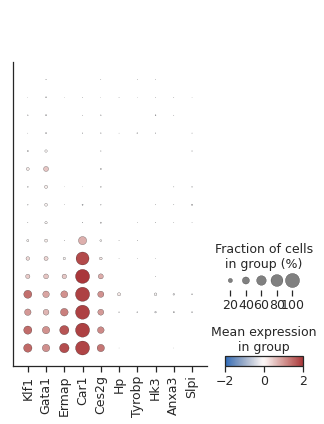

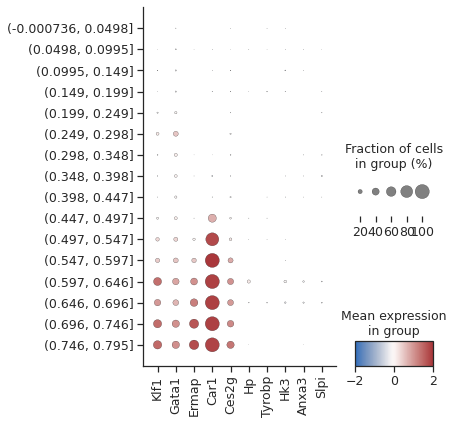

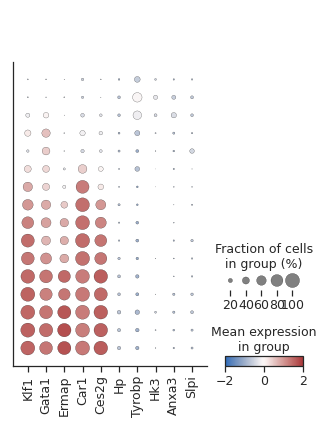

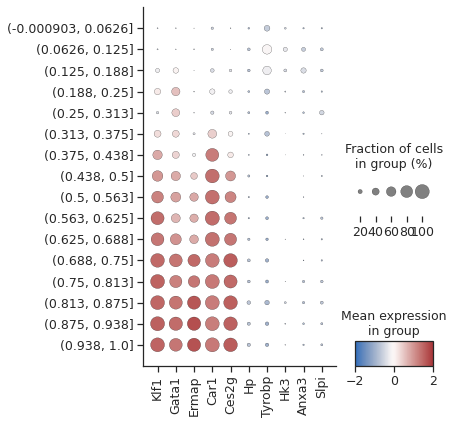

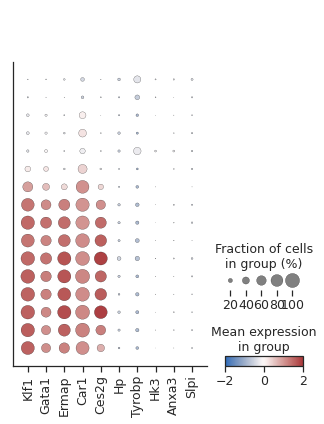

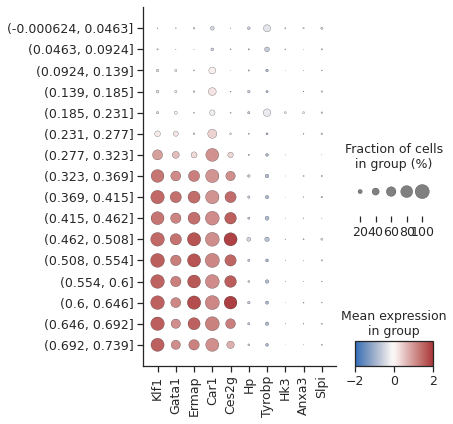

In [582]:
selected_genes = np.concatenate([top_5_eryth,top_5_mono])
for study in combined_adata.obs.study_id.unique():
    print(study)
    scaled_adata = combined_adata[:,selected_genes]
    scaled_adata = scaled_adata[scaled_adata.obs.study_id==study]
    sc.pp.scale(scaled_adata)
    scaled_adata = scaled_adata[scaled_adata.obs.new_lineage=='Erythroid']

    dp  = sc.pl.dotplot(scaled_adata,
                  np.concatenate([top_5_eryth,top_5_mono]), 
                  groupby='monocle_ps', 
                  num_categories=16,
                  return_fig=True,
                  vmin=-2,
                  vmax=2,
                  mean_only_expressed=False,
                  cmap='vlag',
                  show=False)
    dp.get_axes()
    dp.ax_dict['mainplot_ax'].set_yticks([])
    
    dp.savefig(f'/home/bharris/pseudotime/figures/pseudotime_gene_signatures/dotplot_top_lineage_erythroid_{study}.pdf',
               transparent=True)

dahlin


/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


weinreb2


/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


weinreb9


/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


weinreb16


/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


tusi_batch1


/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


tusi_batch2
rf_LARRY1


/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


cheng


/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


giladi


/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


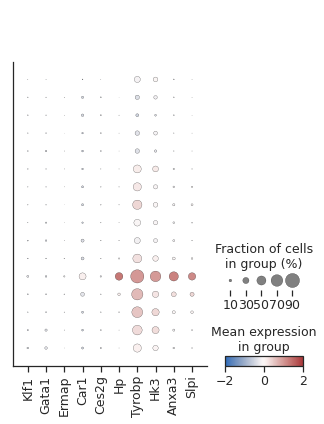

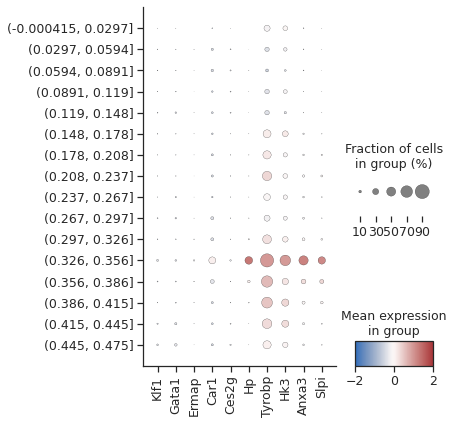

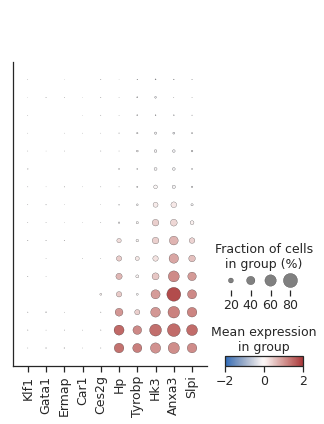

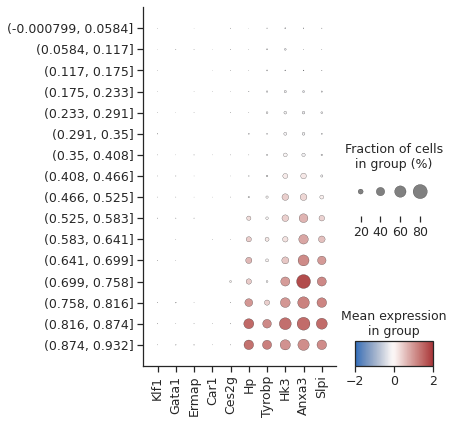

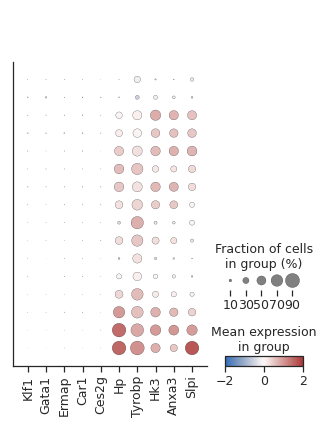

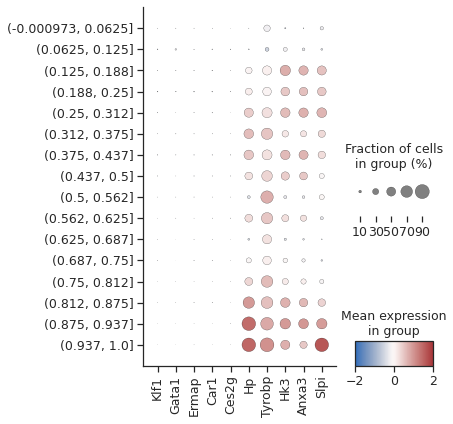

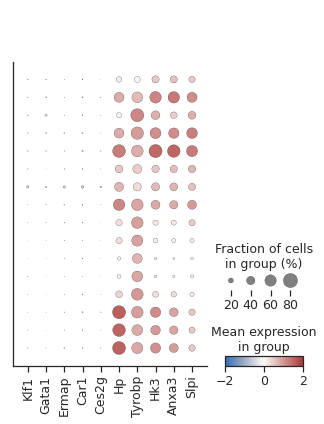

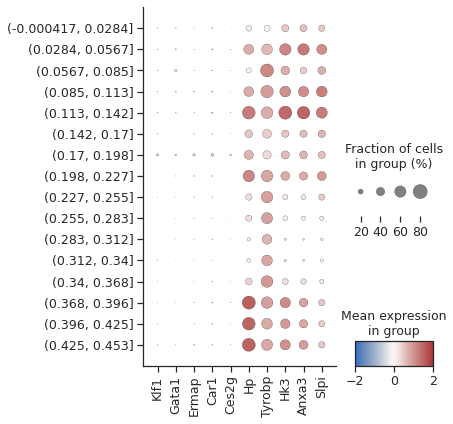

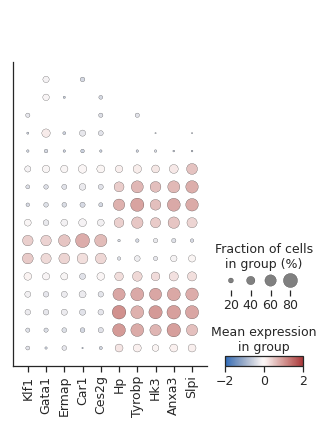

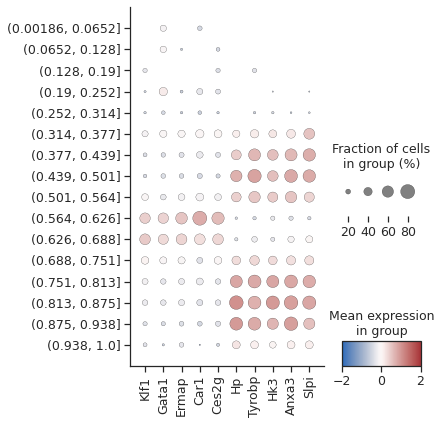

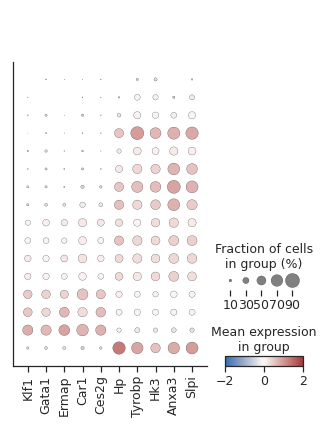

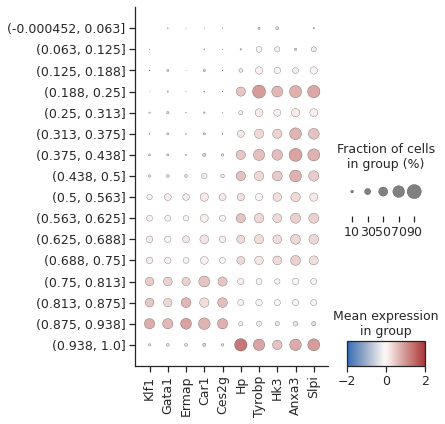

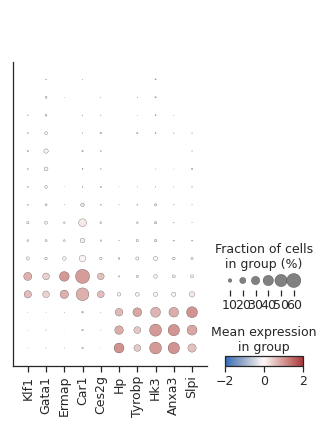

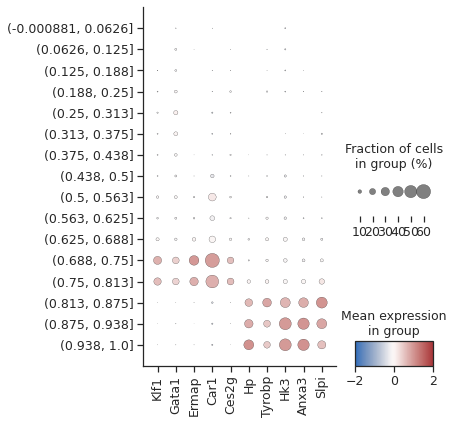

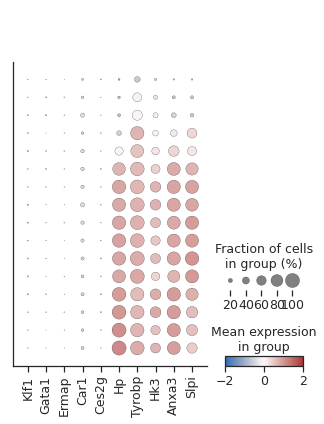

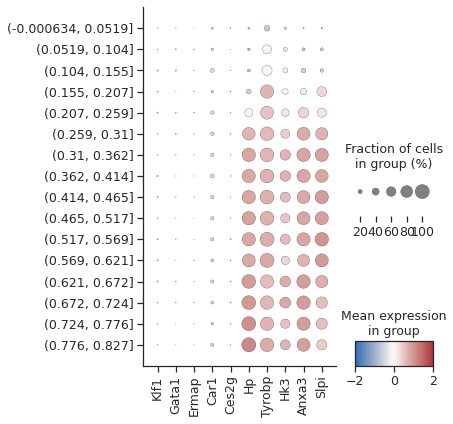

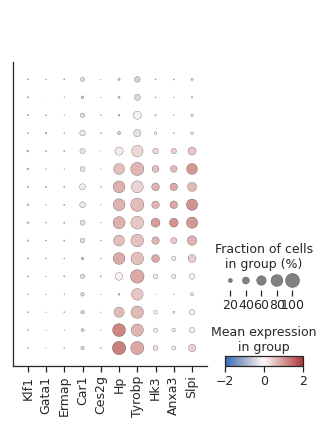

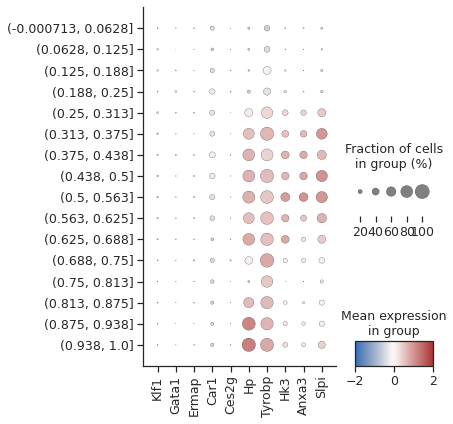

In [583]:
selected_genes = np.concatenate([top_5_eryth,top_5_mono])
for study in combined_adata.obs.study_id.unique():
    print(study)
    scaled_adata = combined_adata[:,selected_genes]
    scaled_adata = scaled_adata[scaled_adata.obs.study_id==study]
    sc.pp.scale(scaled_adata)
    scaled_adata = scaled_adata[scaled_adata.obs.new_lineage=='Monocyte']

    dp  = sc.pl.dotplot(scaled_adata,
                  np.concatenate([top_5_eryth,top_5_mono]), 
                  groupby='monocle_ps', 
                  num_categories=16,
                  return_fig=True,
                  vmin=-2,
                  vmax=2,
                  mean_only_expressed=False,
                  cmap='vlag',
                  show=False)
    dp.get_axes()
    dp.ax_dict['mainplot_ax'].set_yticks([])
    
    dp.savefig(f'/home/bharris/pseudotime/figures/pseudotime_gene_signatures/dotplot_top_lineage_monocyte_{study}.pdf',
               transparent=True)